# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [4]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [7]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [14]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [17]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4097.520203,0.9998,-131.886217,1912.58,1780.693783
OMUSDT,526.319895,1872.677098,0.4570,0.000000,1346.36,1346.360000
BTCUSDT,601.021649,908.215178,0.2216,3.537078,307.19,310.727078
JASMYUSDT,387.458505,496.364590,0.1211,0.000000,108.91,108.910000
SOLUSDT,281.200518,377.568641,0.0921,0.000000,96.37,96.370000
ETHUSDT,250.747339,261.160909,0.0637,0.000000,10.41,10.410000
TRXUSDT,76.868953,129.453073,0.0316,-10.723889,52.58,41.856111
BBUSDT,60.176053,50.883771,0.0124,-39.733101,-9.29,-49.023101
BNBUSDT,1.142121,1.196939,0.0003,-10.606040,0.05,-10.556040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [19]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [20]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [21]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [22]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [24]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [25]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [26]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [27]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_3672\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [28]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23          NaN
2024-09-24    23.503339
2024-09-25    -7.470131
2024-09-26    85.699217
2024-09-27    16.519121
                ...    
2024-12-13    14.587632
2024-12-14   -66.766165
2024-12-15    83.702526
2024-12-16     5.572962
2024-12-17    -3.056273
Name: Total, Length: 86, dtype: float64

In [29]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-13    1870.107467
2024-12-14    1803.341302
2024-12-15    1887.043828
2024-12-16    1892.616790
2024-12-17    1889.560517
Name: Total, Length: 86, dtype: float64

In [30]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [31]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [32]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [33]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_3672\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [34]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [35]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [36]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

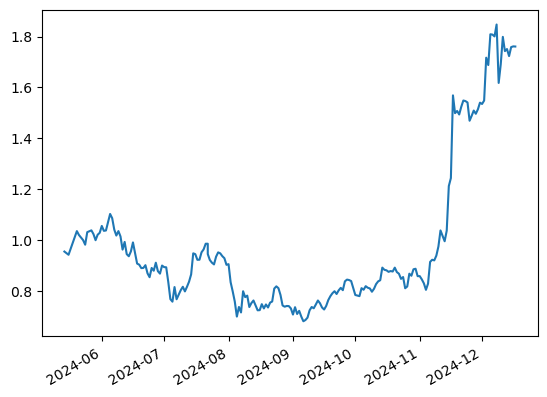

In [37]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [39]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [42]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [43]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'ENSUSDT', 'EOSUSDT', 'ETCUSDT',
       'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT',
       'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT',
       'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MKRUSDT',
       'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT', 'QNTUSDT', 'RAYUSDT',
       'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT',
       'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT',
       'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

In [44]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [47]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3960
BNBUSDT,0.1874
PEPEUSDT,0.1172
SUIUSDT,0.1033
XRPUSDT,0.0859
TRXUSDT,0.0594
XLMUSDT,0.0261
JASMYUSDT,0.0177
AAVEUSDT,0.0070
BONKUSDT,0.0000


In [48]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.372596
BTCUSDT,0.300000
SUIUSDT,0.081899
PEPEUSDT,0.080086
TRXUSDT,0.051953
BNBUSDT,0.050252
XRPUSDT,0.038653
XLMUSDT,0.015612
JASMYUSDT,0.008948


### Current results

In [50]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [51]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.485239
OMUSDT,0.347266
TRXUSDT,0.167496


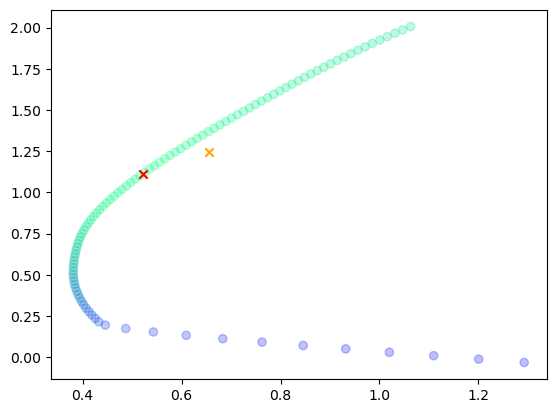

In [52]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [54]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1872.677098,0.457027,0.347266,0.109761
BTCUSDT,908.215178,0.221650,0.485239,-0.263589
JASMYUSDT,496.364590,0.121138,0.000000,0.000000
SOLUSDT,377.568641,0.092146,0.000000,0.000000
ETHUSDT,261.160909,0.063736,0.000000,0.000000
TRXUSDT,129.453073,0.031593,0.167496,-0.135903
BBUSDT,50.883771,0.012418,0.000000,0.000000
BNBUSDT,1.196939,0.000292,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [55]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1872.677098,0.457027,0.372596,0.084431
BTCUSDT,908.215178,0.221650,0.300000,-0.078350
JASMYUSDT,496.364590,0.121138,0.008948,0.112190
SOLUSDT,377.568641,0.092146,0.000000,0.000000
ETHUSDT,261.160909,0.063736,0.000000,0.000000
TRXUSDT,129.453073,0.031593,0.051953,-0.020360
BBUSDT,50.883771,0.012418,0.000000,0.000000
BNBUSDT,1.196939,0.000292,0.050252,-0.049960
PEPEUSDT,0.000005,0.000000,0.080086,-0.080086
SUIUSDT,0.000000,0.000000,0.081899,0.000000


# Risk Reward Analysis

In [57]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [58]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

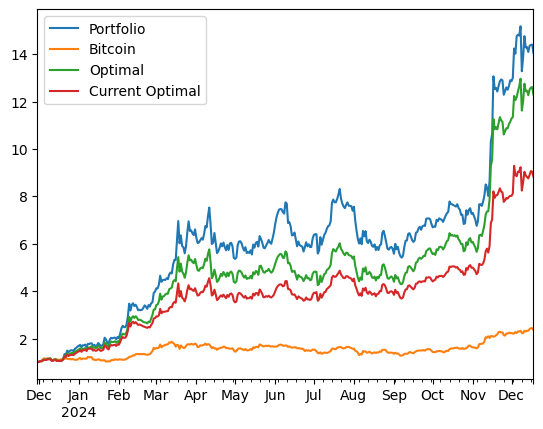

In [59]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [60]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

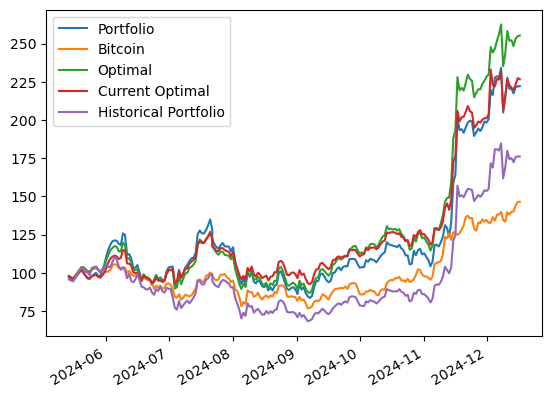

In [61]:
((1+current_perf).cumprod()*100).plot()

In [62]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-08,234.105040,139.857753,262.470937,231.529747,184.701345
2024-12-09,204.844758,134.452552,235.233584,206.807029,161.779517
2024-12-10,214.256948,133.504547,243.372437,215.736118,169.133901
2024-12-11,227.679859,139.625877,258.217833,226.693486,179.858235
2024-12-12,220.337637,138.069846,251.850787,222.848558,174.270669
2024-12-13,220.576659,140.016510,252.188151,221.059301,175.078776
2024-12-14,217.396828,140.010643,248.382398,219.719349,172.317363
2024-12-15,221.401050,144.151053,253.298286,223.327439,175.836410
2024-12-16,221.998789,146.334930,254.896993,227.405248,176.121825
2024-12-17,222.161650,146.438485,255.292183,226.660153,176.070219


## Volatilities

In [64]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.63338
 dtype: float64,
 0.6341780799625006)

In [65]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.655066
 dtype: float64,
 0.6550663707311365)

In [66]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.730579
Bitcoin            0.433869
Optimal            0.634178
Current Optimal    0.577687
dtype: float64

In [67]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4622366349355461

## Risk Contribution

In [69]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.080408,0.050252,0.005952,0.018092,0.001433,0.016659
BTCUSDT,0.407266,0.300000,0.032221,0.134673,0.042125,0.092548
JASMYUSDT,0.019621,0.008948,0.001302,0.006198,0.000252,0.005946
OMUSDT,19.675524,0.372596,0.913327,0.666391,0.560843,0.105547
PEPEUSDT,0.398384,0.080086,0.021798,0.080409,0.025548,0.054861
SUIUSDT,0.231854,0.081899,0.014294,0.055407,0.015294,0.040114
TRXUSDT,0.046472,0.051953,0.004484,0.015347,0.003214,0.012133
XLMUSDT,0.020255,0.015612,0.001634,0.006265,0.000360,0.005905
XRPUSDT,0.070861,0.038653,0.004989,0.017217,0.001634,0.015584


In [70]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.920118,0.347266,0.557791,0.625248,0.499686,0.125562
BTCUSDT,0.250537,0.485239,0.323824,0.244751,0.145820,0.098931
TRXUSDT,0.101493,0.167496,0.118385,0.130001,0.079771,0.050230


In [71]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.231130,0.464646,0.700719,0.689257,0.568532,0.120725
BTCUSDT,0.114737,0.222222,0.139236,0.085537,0.019437,0.066100
JASMYUSDT,0.035584,0.121212,0.064790,0.115741,0.040891,0.074850
SOLUSDT,0.017884,0.090909,0.044955,0.061004,0.007945,0.053059
ETHUSDT,0.007624,0.060606,0.028193,0.026798,0.002530,0.024268
TRXUSDT,0.018362,0.030303,0.020109,0.011550,0.001659,0.009890
BBUSDT,-0.005268,0.010101,0.001997,0.010113,0.000397,0.009716


# Value At Risk

## Historical

### Optimal Weights

In [75]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05106990436048215, -0.07435734427743405)

### Current Weights

In [77]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04751545634925869, -0.07523810504435331)

In [78]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [79]:
var=historical_var.iloc[row]
var

OMUSDT      -0.018079
BTCUSDT     -0.011387
JASMYUSDT   -0.009844
SOLUSDT     -0.006930
ETHUSDT      0.000953
TRXUSDT     -0.001889
BBUSDT      -0.000126
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047302
Name: 2024-11-25 00:00:00, dtype: float64

In [80]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.043991
BTCUSDT     -0.007667
JASMYUSDT   -0.010796
SOLUSDT     -0.006181
ETHUSDT     -0.002453
TRXUSDT     -0.000939
BBUSDT      -0.000884
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072910
dtype: float64

## Parametric

### Optimal Weights

In [83]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06571102069678321, -0.08422336044226161)

### Current Weights

In [85]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06787538264871228, -0.08699747405169703)

## Multivariate

### Optimal Weights

In [88]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.058156358873216976, -0.07509019803853954)

### Current Weights

In [90]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06198445576678004, -0.07925806739758096)

In [91]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.042904
BTCUSDT     -0.005723
JASMYUSDT   -0.006870
SOLUSDT     -0.004294
ETHUSDT     -0.001807
TRXUSDT     -0.000634
BBUSDT      -0.000612
Portfolio   -0.062843
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [95]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05800105694970815, -0.07528900206202821)

### Current Weights

In [97]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06220035276562005, -0.07932735983945177)

In [98]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.043534
BTCUSDT     -0.004833
JASMYUSDT   -0.007598
SOLUSDT     -0.003836
ETHUSDT     -0.001592
TRXUSDT     -0.000795
BBUSDT      -0.000730
Portfolio   -0.062917
dtype: float64

## Student Copula

### Optimal Weights

In [101]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05996604695202003, -0.07607995199492831)

### Current Weights

In [103]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06471444455253361, -0.08358492503462357)

In [104]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.043469
BTCUSDT     -0.005358
JASMYUSDT   -0.007870
SOLUSDT     -0.003993
ETHUSDT     -0.001821
TRXUSDT     -0.001017
BBUSDT      -0.000701
Portfolio   -0.064229
dtype: float64

## Gumbel Copula

### Optimal Weights

In [107]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1059665075154915, -0.15061641307006732)

### Current Weights

In [109]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11029588839888699, -0.1572231603138755)

In [110]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.104961
BTCUSDT     -0.002689
JASMYUSDT   -0.004903
SOLUSDT     -0.000809
ETHUSDT     -0.000060
TRXUSDT     -0.000444
BBUSDT       0.000031
Portfolio   -0.113836
dtype: float64

## Monte Carlo

### Optimal

In [113]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [114]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06910517538933031, -0.08559846771471663)

### Current Weights

In [116]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06945812340174133, -0.08558035822518244)

In [117]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.048692
BTCUSDT     -0.004965
JASMYUSDT   -0.008190
SOLUSDT     -0.003995
ETHUSDT     -0.001694
TRXUSDT     -0.001098
BBUSDT      -0.000771
Portfolio   -0.069407
dtype: float64

## VaR Violation

In [119]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.054526,-0.092177,-0.074898,-0.024488
2024-01-15,-0.054526,-0.092213,-0.076899,0.020576
2024-01-16,-0.054526,-0.091715,-0.073832,0.040789
2024-01-17,-0.054526,-0.093518,-0.081415,-0.027480
2024-01-18,-0.054526,-0.096288,-0.080510,-0.038525
...,...,...,...,...
2024-12-14,-0.087577,-0.127850,-0.110923,-0.015091
2024-12-15,-0.087577,-0.105765,-0.095902,0.019792
2024-12-16,-0.087577,-0.105443,-0.093748,0.006312
2024-12-17,-0.087577,-0.075229,-0.071067,0.001550


In [120]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035656,-0.084479,-0.078613,-0.017161
2024-05-29,-0.035656,-0.081879,-0.075058,-0.008773
2024-05-30,-0.035656,-0.071851,-0.070025,0.036836
2024-05-31,-0.035656,-0.073005,-0.065977,0.039384
2024-06-01,-0.035656,-0.076751,-0.067582,0.054027
...,...,...,...,...
2024-12-14,-0.112004,-0.116606,-0.104635,-0.014416
2024-12-15,-0.112004,-0.116558,-0.107444,0.018419
2024-12-16,-0.112004,-0.116385,-0.109369,0.002700
2024-12-17,-0.112004,-0.116471,-0.110586,0.000734


<Axes: >

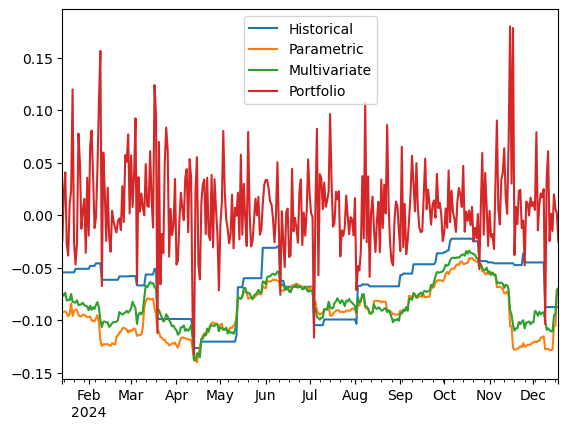

In [121]:
var_data.plot()

<Axes: >

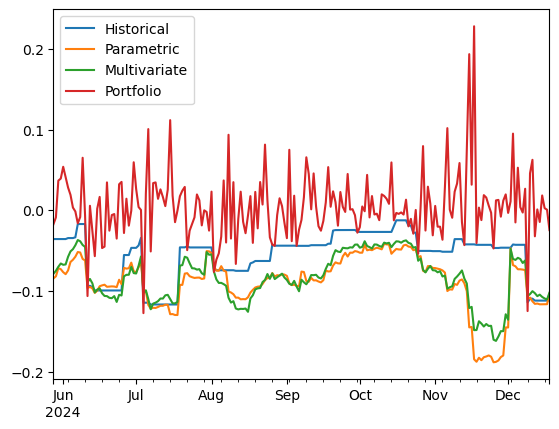

In [122]:
current_var_data.plot()

In [123]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.026471,0.011765,0.014706
Kupiec Stat,4.748729,14.940986,12.202645
P-value,0.02932,0.000111,0.000477


In [124]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.068293,0.019512,0.019512
Kupiec Stat,1.302505,5.170599,5.170599
P-value,0.253756,0.022972,0.022972


# Principal Component Analysis

## Historical PCA

In [127]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76644682, 0.07540703, 0.05922856, 0.05245093, 0.04646666])

In [128]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015263
ADAUSDT     0.015766
ALGOUSDT    0.017657
APTUSDT     0.016742
ARBUSDT     0.017494
              ...   
WBTCUSDT    0.009604
WLDUSDT     0.022798
XLMUSDT     0.012412
XRPUSDT     0.010886
XTZUSDT     0.016555
Name: PC1, Length: 61, dtype: float64

<Axes: >

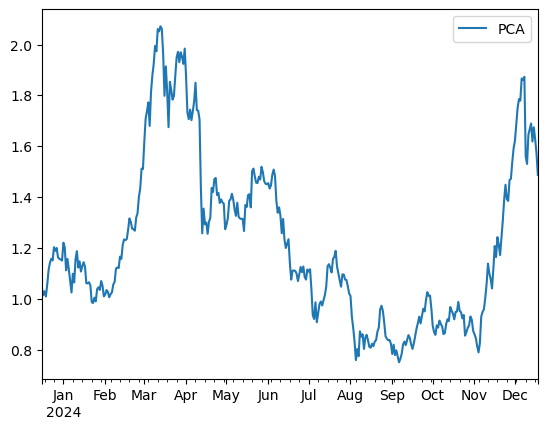

In [129]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

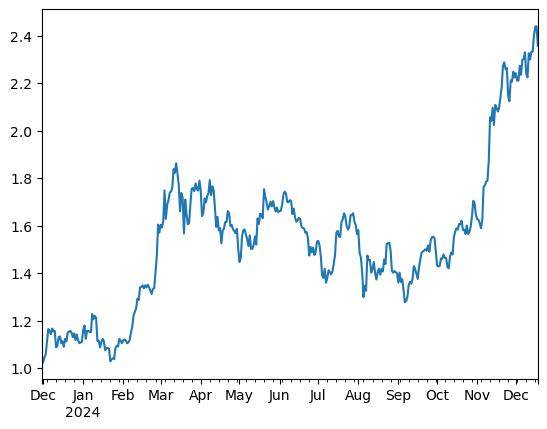

In [130]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [131]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.422967
ETHUSDT      0.422977
FLOWUSDT     0.423383
ATOMUSDT     0.451783
               ...   
FLOKIUSDT    1.127328
BONKUSDT     1.129291
WLDUSDT      1.132619
PEPEUSDT     1.181135
OMUSDT       1.533772
Length: 62, dtype: float64

<Axes: >

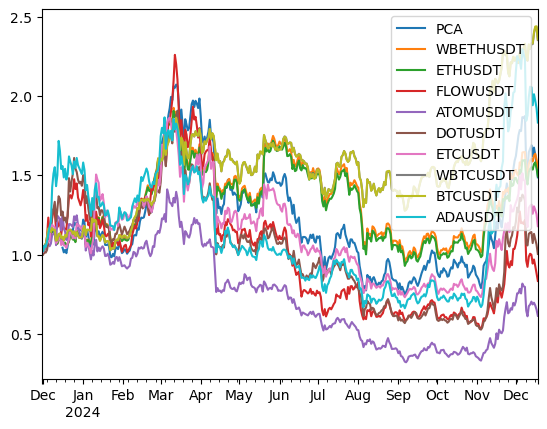

In [132]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

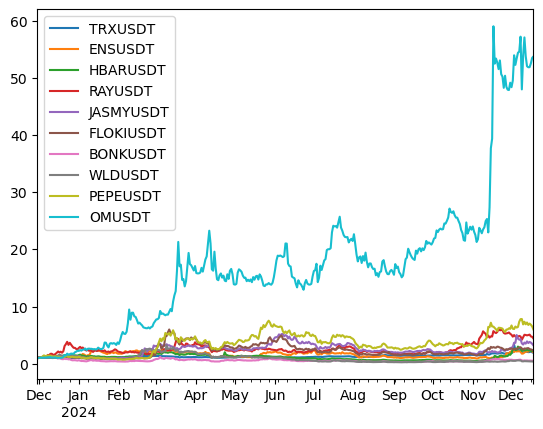

In [133]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [135]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.53488407, 0.15255491, 0.13391381, 0.10289628, 0.07575093])

In [136]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.099338
BTCUSDT      0.061393
JASMYUSDT    0.168245
SOLUSDT      0.100889
ETHUSDT      0.082285
TRXUSDT      0.049743
BBUSDT       0.215987
BNBUSDT      0.067065
PEPEUSDT     0.155055
Name: PC1, dtype: float64

<Axes: >

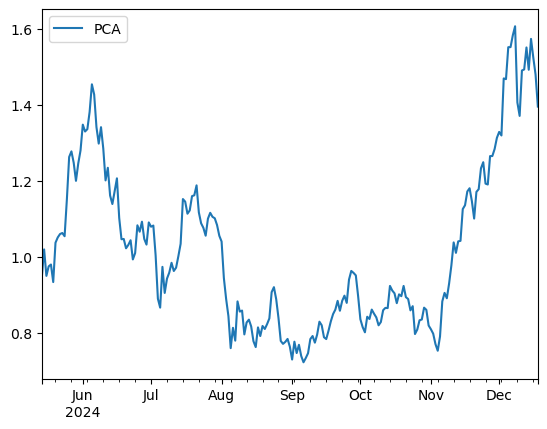

In [137]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

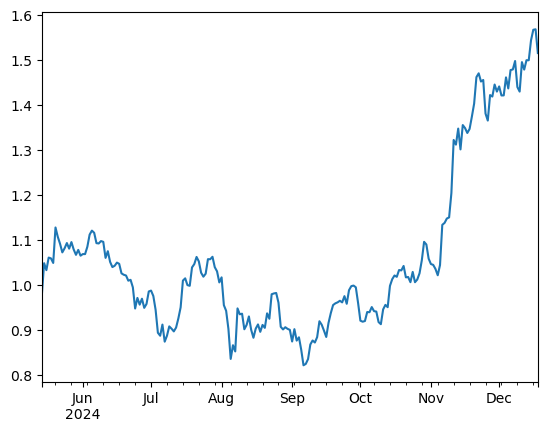

In [138]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [139]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.395674
ETHUSDT      0.412341
BNBUSDT      0.419533
BTCUSDT      0.434108
JASMYUSDT    0.647163
PEPEUSDT     0.713420
BBUSDT       0.733811
TRXUSDT      0.885980
OMUSDT       0.890618
dtype: float64

<Axes: >

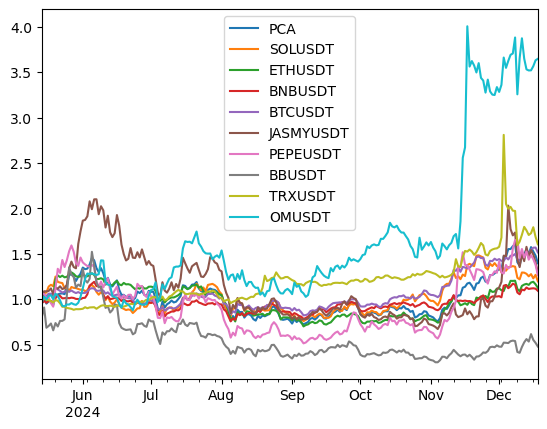

In [140]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [142]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.897882
BBUSDT       1.582558
JASMYUSDT    1.251306
SOLUSDT      1.144323
BTCUSDT      1.000000
ETHUSDT      0.955636
OMUSDT       0.884275
BNBUSDT      0.662079
TRXUSDT      0.271728
Name: BTCUSDT, dtype: float64

In [143]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.813383
PEPEUSDT     1.548707
ETHUSDT      1.349722
OMUSDT       1.027368
JASMYUSDT    1.014038
BTCUSDT      1.000000
BNBUSDT      0.994448
SOLUSDT      0.974133
TRXUSDT      0.784442
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [145]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [146]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BNBUSDT,0.347578
ETHUSDT,0.278108
BBUSDT,0.273391
BTCUSDT,0.261460
OMUSDT,0.196094
JASMYUSDT,0.085155
PEPEUSDT,-0.024184
TRXUSDT,-0.058067
SOLUSDT,-0.109390


### Regression to PCA

In [148]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.757137111963277

In [149]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.258986
BNBUSDT      1.114525
PCA          1.000000
ETHUSDT      0.981450
SOLUSDT      0.801318
JASMYUSDT    0.408779
PEPEUSDT     0.373322
BBUSDT       0.350045
OMUSDT       0.234735
TRXUSDT      0.180742
dtype: float64

In [150]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.917423
BNBUSDT      1.638271
ETHUSDT      1.377440
SOLUSDT      1.203399
PCA          1.000000
OMUSDT       0.517588
BBUSDT       0.503326
TRXUSDT      0.287571
PEPEUSDT     0.282516
JASMYUSDT    0.180625
dtype: float64

### Correlation Matrix

<Axes: >

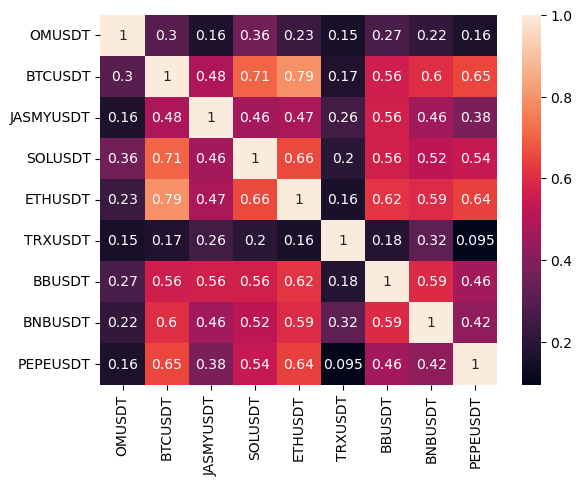

In [152]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

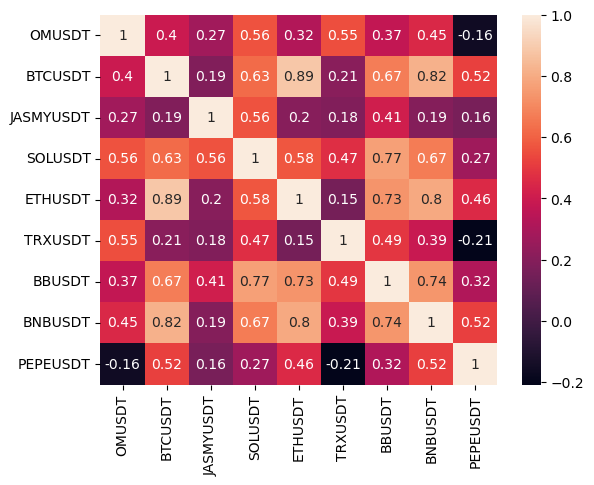

In [153]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [155]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [156]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-12,0.007546,0.0,0.0,0.000000,0.0,0.158399,0.0,0.0,0.0,0.0,...,0.821027,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-06-11,0.007546,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-07-11,0.007546,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.963463,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-08-10,0.007546,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.806017,0.0
2024-09-09,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-10-09,0.007546,0.0,0.0,0.014632,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.477283,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-11-08,0.007546,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-12-08,0.007546,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.05774,0.0,0.0,0.0,0.0,0.0,0.0,0.211817,0.0
2024-12-18,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [157]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

AAVEUSDT     1.0
JASMYUSDT    0.0
LINKUSDT     0.0
LTCUSDT      0.0
MKRUSDT      0.0
            ... 
GALAUSDT     0.0
GRTUSDT      0.0
HBARUSDT     0.0
ICPUSDT      0.0
XTZUSDT      0.0
Name: 2024-12-18 00:00:00, Length: 61, dtype: float64